In [3]:
import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report , confusion_matrix , accuracy_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

import cv2

from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchvision.transforms as transforms


In [4]:

# Definición de paths para cargar los datos
normal_path = "./Brain_Data_Organised/Normal"
stroke_path = "./Brain_Data_Organised/Stroke"

normal_folder = os.listdir(normal_path)
stroke_folder = os.listdir(stroke_path)
print("Images in Normal Data:", len(normal_folder))
print("Images in Stroke Data:", len(stroke_folder))

data = []
labels = []

# Carga imágenes normales
for img_file in normal_folder:
    image = Image.open(os.path.join(normal_path, img_file)).convert('RGB')
    image = image.resize((224, 224))
    image = np.array(image)
    data.append(image)
    labels.append(0)  # Etiqueta Normal

# Carga imágenes de Ictus
for img_file in stroke_folder:
    image = Image.open(os.path.join(stroke_path, img_file)).convert('RGB')
    image = image.resize((224, 224))
    image = np.array(image)
    data.append(image)
    labels.append(1)  # Etiqueta Stroke

x = np.array(data)
y = np.array(labels)

Images in Normal Data: 1551
Images in Stroke Data: 950


In [5]:
# Partimos en train y test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.10, shuffle=True, random_state=42)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

# Conversión a torch tensors
x_train = torch.tensor(x_train, dtype=torch.float32).permute(0, 3, 1, 2)
x_test = torch.tensor(x_test, dtype=torch.float32).permute(0, 3, 1, 2)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Creamos Dataset
train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)

#  train_dataset dividido en  training y validation datasets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

(2250, 224, 224, 3)
(251, 224, 224, 3)
(2250,)
(251,)


In [6]:
class ImprovedCNNModel(nn.Module):
    def __init__(self):
        super(ImprovedCNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.pool = nn.MaxPool2d(kernel_size=2)
        self.dropout = nn.Dropout(0.1)  # Reducimos dropout

        # tamaño después de convolutions y pooling
        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 1)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.bn1(self.conv1(x))))
        x = self.pool(nn.functional.relu(self.bn2(self.conv2(x))))
        x = self.pool(nn.functional.relu(self.bn3(self.conv3(x))))

        x = x.view(x.size(0), -1)
        x = self.dropout(nn.functional.relu(self.fc1(x)))
        x = torch.sigmoid(self.fc2(x))
        return x

# Inicializamos 
model = ImprovedCNNModel()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Reducimos learning rate y weight decay
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
criterion = nn.BCELoss()

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)


In [7]:
# Training con  early stopping
def train_model(model, train_loader, val_loader, num_epochs=30):
    best_val_loss = float('inf')
    patience = 5
    patience_counter = 0

    for epoch in range(num_epochs):
        # Training 
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            running_loss += loss.item()
            predicted = (outputs.data > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total

        # Validación
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device).unsqueeze(1)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                predicted = (outputs.data > 0.5).float()
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_acc = 100 * val_correct / val_total

        # Learning rate scheduling
        scheduler.step(val_loss)

        # Comprobamos Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            # Salvamos el mejor modelo
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping triggered at epoch {epoch+1}')
                break

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')


train_model(model, train_loader, val_loader)

Epoch [1/30], Loss: 0.9404, Acc: 66.06%, Val Loss: 0.4512, Val Acc: 76.67%
Epoch [2/30], Loss: 0.2937, Acc: 86.39%, Val Loss: 0.2195, Val Acc: 89.33%
Epoch [3/30], Loss: 0.1618, Acc: 94.22%, Val Loss: 0.2565, Val Acc: 88.00%
Epoch [4/30], Loss: 0.1014, Acc: 96.50%, Val Loss: 0.1047, Val Acc: 95.11%
Epoch [5/30], Loss: 0.0809, Acc: 96.78%, Val Loss: 0.1159, Val Acc: 95.11%
Epoch [6/30], Loss: 0.0319, Acc: 99.11%, Val Loss: 0.0786, Val Acc: 96.22%
Epoch [7/30], Loss: 0.0433, Acc: 98.72%, Val Loss: 0.5091, Val Acc: 84.89%
Epoch [8/30], Loss: 0.0153, Acc: 99.44%, Val Loss: 0.0631, Val Acc: 97.11%
Epoch [9/30], Loss: 0.0065, Acc: 99.78%, Val Loss: 0.0660, Val Acc: 97.78%
Epoch [10/30], Loss: 0.0028, Acc: 99.94%, Val Loss: 0.0668, Val Acc: 97.11%
Epoch [11/30], Loss: 0.0012, Acc: 100.00%, Val Loss: 0.0606, Val Acc: 96.89%
Epoch [12/30], Loss: 0.0029, Acc: 100.00%, Val Loss: 0.0570, Val Acc: 97.56%
Epoch [13/30], Loss: 0.0025, Acc: 100.00%, Val Loss: 0.1594, Val Acc: 94.22%
Epoch [14/30], Los

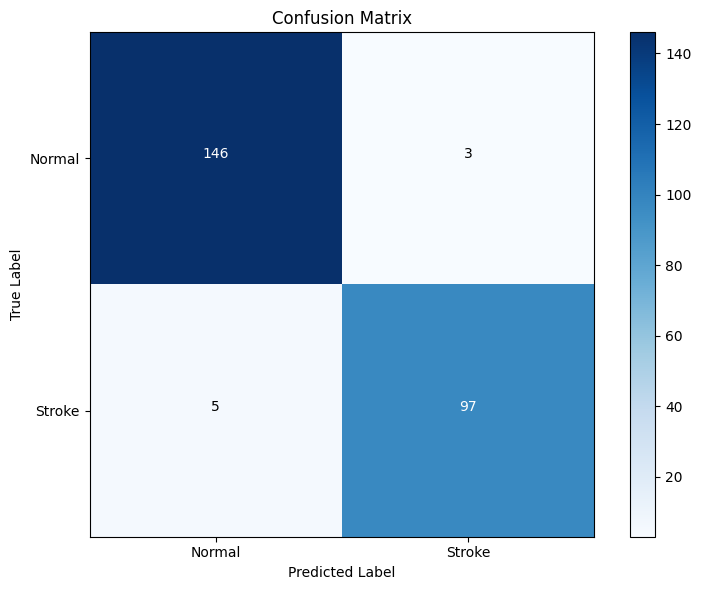


Classification Report:
              precision    recall  f1-score   support

      Normal       0.97      0.98      0.97       149
      Stroke       0.97      0.95      0.96       102

    accuracy                           0.97       251
   macro avg       0.97      0.97      0.97       251
weighted avg       0.97      0.97      0.97       251


Accuracy: 0.9681
Recall: 0.9510
F1 Score: 0.9604


In [8]:
# Evaluamos en el dataset de testing, no se ha tocado.
def evaluate_model(model, test_loader, device):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            predicted = (outputs.data > 0.5).float().cpu()
            all_predictions.extend(predicted.numpy().flatten())
            all_labels.extend(labels.numpy().flatten())

    #  confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    # Métricas 
    accuracy = accuracy_score(all_labels, all_predictions)
    recall = recall_score(all_labels, all_predictions)
    f1 = f1_score(all_labels, all_predictions)

    # Mostrar la matriz de confusión 
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    classes = ['Normal', 'Stroke']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    print("\nClassification Report:")
    print(classification_report(all_labels, all_predictions, target_names=classes))
    print(f"\nAccuracy: {accuracy:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")


evaluate_model(model, test_loader, device)

In [9]:
# Guardamos el modelo
torch.save(model.state_dict(), 'vision_stroke_98.pth')